<h1 align='center'> Modelo Quarter-Car como um Sistema Linear Invariante no Tempo </h1>

In [1]:
#Importando bibliotecas:
import numpy as np
import control as ct
import warnings
import matplotlib.pyplot as plt
import scienceplots

warnings.filterwarnings("ignore")

# Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 20

title = False 

#Exibição dos gráficos em no notebook:
%matplotlib inline

'''
#Exibição dos gráficos em janela externa:
%matplotlib qt
'''

def mag2db(mag):
    return (20*np.log10(mag))

### Parâmetros do sistema:

In [2]:
# Unidades no S.I [Kg, N/m, (N*s)/m]:
# GDL não suspenso:
mu = 75
ku = 193000

# GDL suspenso:
ms = 375
ks = 35000
cs = 1800

### Definição das matrizes $$[M],~[C],~[K]$$ e condições iniciais:

In [3]:
# Fator de correção para cálculos:
fc = 1e0

# Matriz das massas (Kg):
M = np.array([
    [mu, 0,],
    [0, ms]
], dtype=float)*fc

# Matriz de amortecimento (N*s/m):
C = np.array([
    [cs, -cs],
    [-cs, cs]
], dtype=float)*fc

# Matriz de rigidez (N/m):
K = np.array([
    [(ks+ku), -ks],
    [-ks, ks]
], dtype=float)*fc

# Matriz de posições iniciais (transposta):
X0 = np.array([0, 0], dtype=float).T

# Matriz de velocidades iniciais (transposta):
V0 = np.array([0, 0], dtype=float).T

### Montando o LTI no formato $$\dot{[X]} = [A][X]+[B][U] ~~~~ e ~~~~ [Y] = [C][X] + [D][U]:$$

In [4]:
N = len(M)

A = np.block([
    [np.zeros((N, N)), np.eye(N)],
    [-np.linalg.inv(M)@K, -np.linalg.inv(M)@C]
])

B = np.block([
    [np.zeros((2, 1))],
    [np.array([
        [(ku/mu)], 
        [0]
    ])]
])

C = np.block([
    [np.eye(N), np.zeros((N, N))],
    [np.zeros((N, 2*N))]
])

D = np.zeros((2*N, 1))

system = ct.ss(A, B, C, D)

### Excitação externa por perfil de pista:

##### Entrada Harmônica:

In [5]:
# Tempo de amostragem:
ts = 1e-2

# Tempo de simulação:
tf = 12

# Velocidade do carro em Km/h:
v_car = [9, 18, 36, 54, 72, 108, 162]

# Amplitude em mm:
amplitude = [100]

# Espaçamento em m:
esp = 3

# Offset em mm:
offset = 0

# Criação do vetor de tempo:
time = np.arange(0, tf, ts)

'''
road = []
for v in v_car:
    for a in amplitude:
        freq = round(((v*2*np.pi)/(3.6*esp)), 4)
        print(freq)
        road.append(np.array(a*np.sin(freq*time)*1e-3))
xvalues = np.array(time*np.min(v_car)/3.6)
'''

freqs = [0.52, 8.87, 35.0, 55.27, 90.0]
road = []
for f in freqs:
    print(f)
    road.append(np.array(amplitude[0]*np.sin(f*time)*1e-3))
xvalues = np.array(time*np.min(v_car)/3.6)

0.52
8.87
35.0
55.27
90.0


### Encontrando as Frequências Naturais:

In [6]:
# Cálculo de M^(-1/2):
MM = np.power(M, -1/2)  # Inverso da raíz quadrada
MM[MM == np.inf] = 0  # Transforma os elementos infinitos em zero

ktil = MM@K@MM  # Cálculo da matriz ktil 
lamb, p = np.linalg.eig(ktil) # Obtenção dos autovalores

omega_n = np.sqrt(lamb)

labels = ['u', 's']
for i in range(len(omega_n)):
    print(f'w{labels[i]} = {round((omega_n[i]), 4)} rad/s')

wu = 55.2694 rad/s
ws = 8.8671 rad/s


### Resposta Forçada:

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


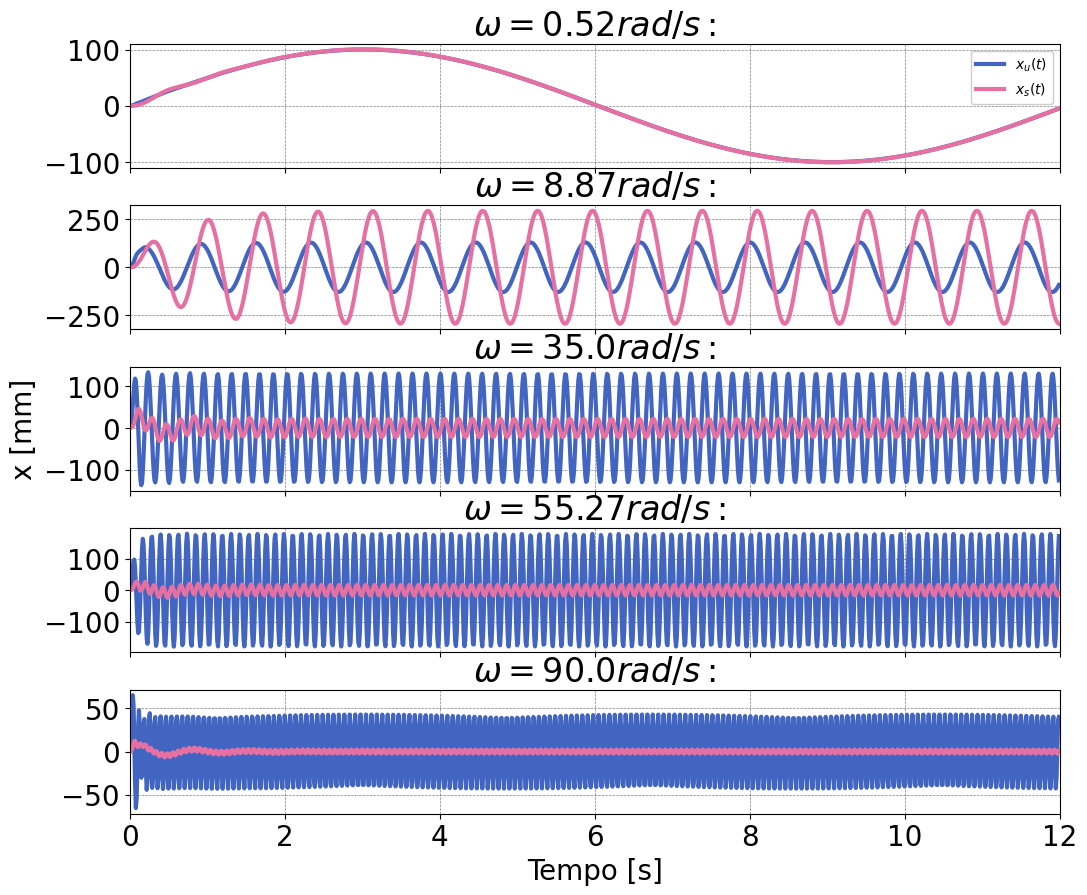

In [10]:
plt.rcParams['figure.figsize'] = (12, 10)
fig, ax = plt.subplots(5, sharex=True)
for n in range(len(road)):
    time, y = ct.forced_response(system, T=time, U=(road[n]), X0=np.block([X0.T, V0.T]))
    
    plt.subplot(5, 1, (n+1))
    plt.plot(time, (y[0]*1e3), label='$x_u(t)$')
    plt.plot(time, (y[1]*1e3), label='$x_s(t)$')
    plt.title(f'$\omega = {freqs[n]}rad/s:$')
plt.xlabel('Tempo [s]')
plt.subplots_adjust(hspace=0.3)
plt.subplot(5, 1, 3)
plt.ylabel('x [mm]')
plt.subplot(5, 1, 1)
plt.legend(fontsize=10)
plt.xlim(0, tf)
if(title):
    plt.title('Resposta Temporal Real')
plt.savefig('curves/TR.eps', dpi=600, transparent=True)